### Regression with a neural network

We fit a neural-network regressor to a smooth “bowl + ripples” function $z=f(x,y)$ by sampling noisy points $(x,y)\in[0,1]^2$, training a small ReLU MLP (He initialization) with mean-squared error and early stopping, then visualizing ground truth vs. predictions as 3D surfaces with an optional error heatmap.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.cm as cm
from tensorflow.keras import layers, regularizers

Defines a bumpy “bowl + ripples” surface 
𝑓
(
𝑥
,
𝑦
)
f(x,y), samples 6,000 
(
𝑥
,
𝑦
)
∈
[
0
,
1
]
2
(x,y)∈[0,1]
2
 points and noisy targets 
𝑧
z, then shuffles and splits them into train/val/test sets (4,800/600/600).

In [ ]:

# ---------- 1) Make a synthetic "ground-truth" surface ----------
# Bowl + ripples (tweak to resemble your plot)
def f(x, y):
    return (
        2.0
        + 1.2*((x-0.5)**2 + (y-0.5)**2)
        + 0.8*np.sin(4*np.pi*x)*np.cos(3*np.pi*y)
    )

# sample training data
N = 6000
xy = np.random.rand(N, 2)                     # (x,y) in [0,1]^2
z  = f(xy[:,0], xy[:,1]) + 0.03*np.random.randn(N)  # small noise

# split: train/val/test
idx = np.arange(N); np.random.shuffle(idx)
train, val, test = idx[:4800], idx[4800:5400], idx[5400:]
x_train, y_train = xy[train], z[train]
x_val,   y_val   = xy[val],   z[val]
x_test,  y_test  = xy[test],  z[test]

Prints the number of samples in the training and test sets by reading the first dimension of x_train and x_test.

In [4]:
print('Number of training datapoints:', x_train.shape[0])
print('Number of testing datapoints:', x_test.shape[0])

Number of training datapoints: 4800
Number of testing datapoints: 600


Creates a 3D triangulated surface of the training data 
𝑧
z over scattered 
(
𝑥
,
𝑦
)
(x,y) points using plot_trisurf with the Viridis colormap, labels the axes/title, and displays the figure (ensure from matplotlib import cm).

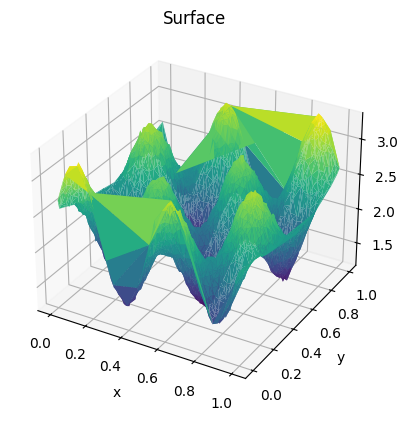

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})


ax.plot_trisurf(x_train[:, 0], x_train[:, 1], y_train, vmin=y_train.min(), cmap=cm.viridis)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Surface')
plt.show()

Builds a 3-hidden-layer ReLU MLP (He init + L2 on first two layers), compiles with MSE and Adam(3e-4), trains with early stopping (20 epochs, batch 10, 20% validation), then plots train/val loss curves and prints the final training and validation errors.

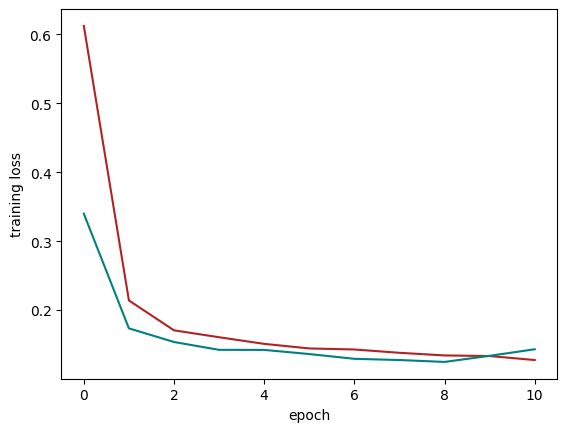

Last training error: 0.12738581001758575
Last validation error: 0.14300698041915894


In [20]:
net = keras.Sequential(
        [
            keras.layers.Input(shape= [x_train.shape[1]]),
            
            keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(1e-4)),
            keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(1e-4)),
            keras.layers.Dense(64,  activation='relu', kernel_initializer='he_normal'),     
            keras.layers.Dense(units= 1)
        ]
    )

net.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate= 3e-4)
    
)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = net.fit(x_train, y_train, validation_split= 0.2, epochs= 20, batch_size= 10, callbacks= [callback], verbose= 0) #callbacks= [callback],

plt.figure()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(history.history['loss'], color= "firebrick")
plt.plot(history.history['val_loss'], color= 'teal')
plt.show()
print('Last training error:', history.history['loss'][-1])
print('Last validation error:', history.history['val_loss'][-1])

In [21]:
y_pred = net.predict(x_test).squeeze(-1)
print('Final test error:', 0.5*((y_pred - y_test)**2).mean())

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step 
Final test error: 0.0565908231121163


Plots a 3D triangulated surface of the test targets 
𝑧
z over the scattered 
(
𝑥
,
𝑦
)
(x,y) test points using plot_trisurf with Viridis, labels axes/title, and shows the figure.

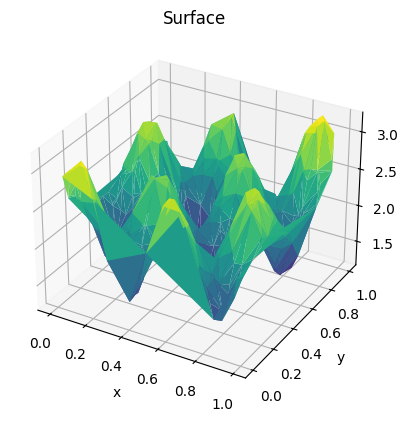

In [22]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})


ax.plot_trisurf(x_test[:, 0], x_test[:, 1], y_test, vmin=y_train.min(), cmap=cm.viridis)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Surface')
plt.show()